In [ ]:
!pip install yfinance
!pip install PyPortfolioOpt #misma que pip install git+https://github.com/robertmartin8/PyPortfolioOpt.git
!pip install jedi # dependencia de ffn
!pip install decorator # dependencia de ffn
!pip install ffn
!pip install arch
!pip install pyfolio

In [ ]:
%matplotlib inline

from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting , HRPOpt, black_litterman, objective_functions, BlackLittermanModel, DiscreteAllocation
import yfinance as yf
import os
import ffn
from cvxopt import blas, solvers
import cvxopt as opt
from google.colab import drive
from sklearn.neighbors import KernelDensity
from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from pypfopt.risk_models import CovarianceShrinkage
from scipy.linalg import sqrtm
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid
import pyfolio as pf;
import seaborn as sns
from arch import arch_model

Importar DF de real_state

In [ ]:

drive.mount('/content/drive')
# Ruta completa del archivo CSV
ruta_archivo = '/content/drive/MyDrive/TP_financial_analytics/USSTHPI.csv'

# Importar el archivo CSV como DataFrame
#df_real_estate = pd.read_csv(ruta_archivo)

df_real_estate = pd.read_csv(ruta_archivo, delimiter = ';')
print(df_real_estate.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       DATE  USSTHPI
0  1/1/2014  84500.0
1  1/2/2014  82200.0
2  1/3/2014  83900.0
3  1/4/2014  83000.0
4  1/5/2014  78300.0


In [ ]:
# Convertir la columna DATE a tipo datetime si aún no lo está
df_real_estate['DATE'] = pd.to_datetime(df_real_estate['DATE'], format = '%d/%m/%Y')

# # Establecer la columna DATE como índice
df_real_estate.set_index('DATE', inplace=True)

# Dividimos por 1000 para que quede en kUSD
df_real_estate['USSTHPI'] = df_real_estate['USSTHPI']/1000

# # Restablecer el índice para que DATE sea una columna nuevamente
df_real_estate.reset_index(inplace=True)

print(df_real_estate.head())
print(df_real_estate.columns)


        DATE  USSTHPI
0 2014-01-01     84.5
1 2014-02-01     82.2
2 2014-03-01     83.9
3 2014-04-01     83.0
4 2014-05-01     78.3
Index(['DATE', 'USSTHPI'], dtype='object')


#Selección de ETFs

ETFs Seleccionados:

*  **IWM**: iShares Russell 2000 ETF
*  **SPY**: SPDR S&P 500 ETF Trust
*  **VXUS**: Vanguard Total International Stock ETF
*  **LQD**: iShares iBoxx $ Investment Grade Corporate Bond ETF
*  **TLT**: iShares 20+ Year Treasury Bond ETF
*  **GLD**: SPDR Gold Shares
*  **XLE**: Energy Select Sector SPDR Fund
*  **XLK**: Technology Select Sector SPDR Fund
*  **XLF**: Financial Select Sector SPDR Fund
*  **EZU**: iShares MSCI Eurozone ETF
*  **EEM**: iShares MSCI Emerging Markets ETF

Decidimos utilizar los siguientes 11 ETFs ya que ofrecen una gran exposición a una variedad de activos subyacentes, incluyendo acciones, bonos corporativos, bonos del tesoro, oro y acciones de sectores específicos (Tecnologia, Financieras, Energia, etc). Permitiendonos, construir una cartera equilibrada y bien diversificada para mitigar el riesgo y maximizar el potencial de rendimiento a largo plazo.

A la hora de armar los retornos decidimos utilizar le **cierre ajustado** debido a que el mismo ayuda a eliminar las distorsiones causadas por eventos corporativos como los dividendos y las divisiones de acciones (splits y reverse splits), lo que proporciona una medida más precisa y consistente del rendimiento de la acción a lo largo del tiempo.

In [ ]:
# Lista de tickers de los ETFs
etf_tickers = ['IWM', 'SPY', 'VXUS', 'LQD', 'TLT', 'GLD', 'XLE', 'XLK', 'XLF', 'EZU', 'EEM']
RISKY_ASSSETS = ['IWM', 'SPY', 'VXUS', 'LQD', 'TLT', 'GLD', 'XLE', 'XLK', 'XLF', 'EZU', 'EEM']
#n_assets va a ser útil a la hora de iterar por la lista de activos
n_assets = len(etf_tickers)
df = yf.download(etf_tickers, start='2014-01-01', end='2022-12-31')

# Reemplazar infinitos y NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 1. Limpiar y preparar los datos
data = df['Adj Close']

print(f'Listado de activos considerados {data.columns}')

print(data.head())




[*********************100%%**********************]  11 of 11 completed


Listado de activos considerados Index(['EEM', 'EZU', 'GLD', 'IWM', 'LQD', 'SPY', 'TLT', 'VXUS', 'XLE', 'XLF',
       'XLK'],
      dtype='object', name='Ticker')
Ticker            EEM        EZU         GLD         IWM        LQD  \
Date                                                                  
2014-01-02  32.273502  31.185854  118.000000   99.790016  82.334030   
2014-01-03  32.217285  31.100878  119.290001  100.297226  82.456367   
2014-01-06  31.912140  31.193579  119.500000   99.483932  82.636292   
2014-01-07  32.048660  31.502581  118.820000  100.314720  82.571518   
2014-01-08  31.944275  31.471689  118.120003  100.445877  82.218903   

Ticker             SPY        TLT       VXUS        XLE        XLF        XLK  
Date                                                                           
2014-01-02  152.669128  80.040108  38.236805  58.996796  14.562067  30.888838  
2014-01-03  152.644058  80.040108  38.221954  58.780449  14.662543  30.740454  
2014-01-06  152.2017

In [ ]:


# Fusionar los DataFrames utilizando el índice como clave en 'data'
merged_df = pd.merge(df_real_estate, data, left_on='DATE', right_index=True)

# Resetear el índice de df_monthly_real_estate para asegurarse de que sea una columna en lugar de un índice
df_real_estate.reset_index(inplace=True)

# Reordenar las columnas para que 'USSTHPI' aparezca al final
columns_order = list(df_real_estate.columns) + list(data.columns)
merged_df = merged_df.reindex(columns=columns_order)

print(merged_df.head())
print(merged_df.columns)



   index       DATE  USSTHPI        EEM        EZU         GLD         IWM  \
3    NaN 2014-04-01     83.0  33.317444  33.001225  123.389999  103.344315   
4    NaN 2014-05-01     78.3  33.229099  33.279335  123.800003   98.145096   
6    NaN 2014-07-01     80.1  35.321140  33.596661  127.699997  105.229370   
7    NaN 2014-08-01     87.6  35.661076  31.029875  124.379997   97.412926   
9    NaN 2014-10-01     76.9  32.949673  29.966934  116.769997   95.138809   

         LQD         SPY        TLT       VXUS        XLE        XLF  \
3  84.446281  157.811096  85.161507  39.336906  60.876991  15.046314   
4  86.141945  157.878204  88.636086  39.621296  63.554268  14.790829   
6  86.750305  165.962952  89.301025  41.439083  68.375420  15.443345   
7  87.256088  162.147141  91.354851  40.235859  65.433128  14.997866   
9  87.587540  164.470718  94.732010  38.325695  60.911705  15.513952   

         XLK  
3  32.240150  
4  31.985950  
6  34.114796  
7  34.158813  
9  34.739197  
Index(['

In [ ]:
merged_df.drop(columns=['index'], inplace=True)
merged_df.set_index('DATE', inplace=True)



print(merged_df.head())

            USSTHPI        EEM        EZU         GLD         IWM        LQD  \
DATE                                                                           
2014-04-01     83.0  33.317444  33.001225  123.389999  103.344315  84.446281   
2014-05-01     78.3  33.229099  33.279335  123.800003   98.145096  86.141945   
2014-07-01     80.1  35.321140  33.596661  127.699997  105.229370  86.750305   
2014-08-01     87.6  35.661076  31.029875  124.379997   97.412926  87.256088   
2014-10-01     76.9  32.949673  29.966934  116.769997   95.138809  87.587540   

                   SPY        TLT       VXUS        XLE        XLF        XLK  
DATE                                                                           
2014-04-01  157.811096  85.161507  39.336906  60.876991  15.046314  32.240150  
2014-05-01  157.878204  88.636086  39.621296  63.554268  14.790829  31.985950  
2014-07-01  165.962952  89.301025  41.439083  68.375420  15.443345  34.114796  
2014-08-01  162.147141  91.354851  40.2

In [ ]:
data = merged_df

In [ ]:
n_assets = len(data.columns)
print(n_assets)

12


# Analisis de metricas utiles:

<Axes: title={'center': 'Stock prices of the considered assets'}, xlabel='DATE'>

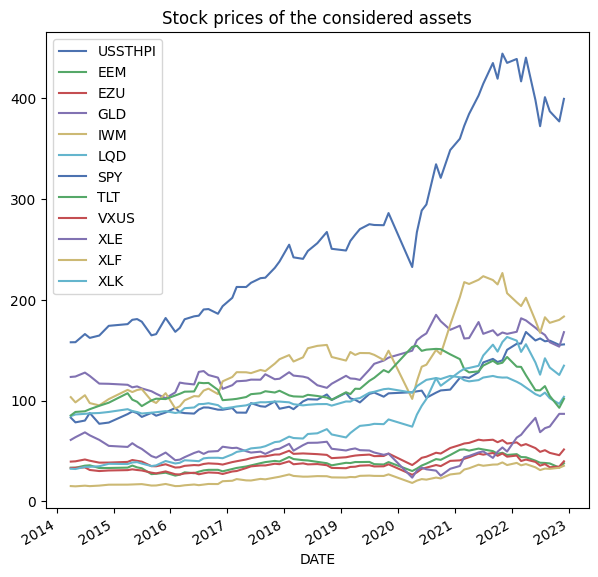

In [ ]:
data.plot(title='Stock prices of the considered assets')


In [ ]:
returns_analysis = data.pct_change().dropna()

In [ ]:
portfolio_weights_analysis = n_assets * [1 / n_assets]

In [ ]:
portfolio_returns_analysis = pd.Series(np.dot(portfolio_weights_analysis, returns_analysis.T),
                              index=returns_analysis.index)

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2014-01-03
End date,2022-01-12
Total months,3
,Backtest
Annual return,1282.8%
Cumulative returns,101.0%
Annual volatility,71.0%
Sharpe ratio,4.05
Calmar ratio,104.15
Stability,0.90
Max drawdown,-12.3%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


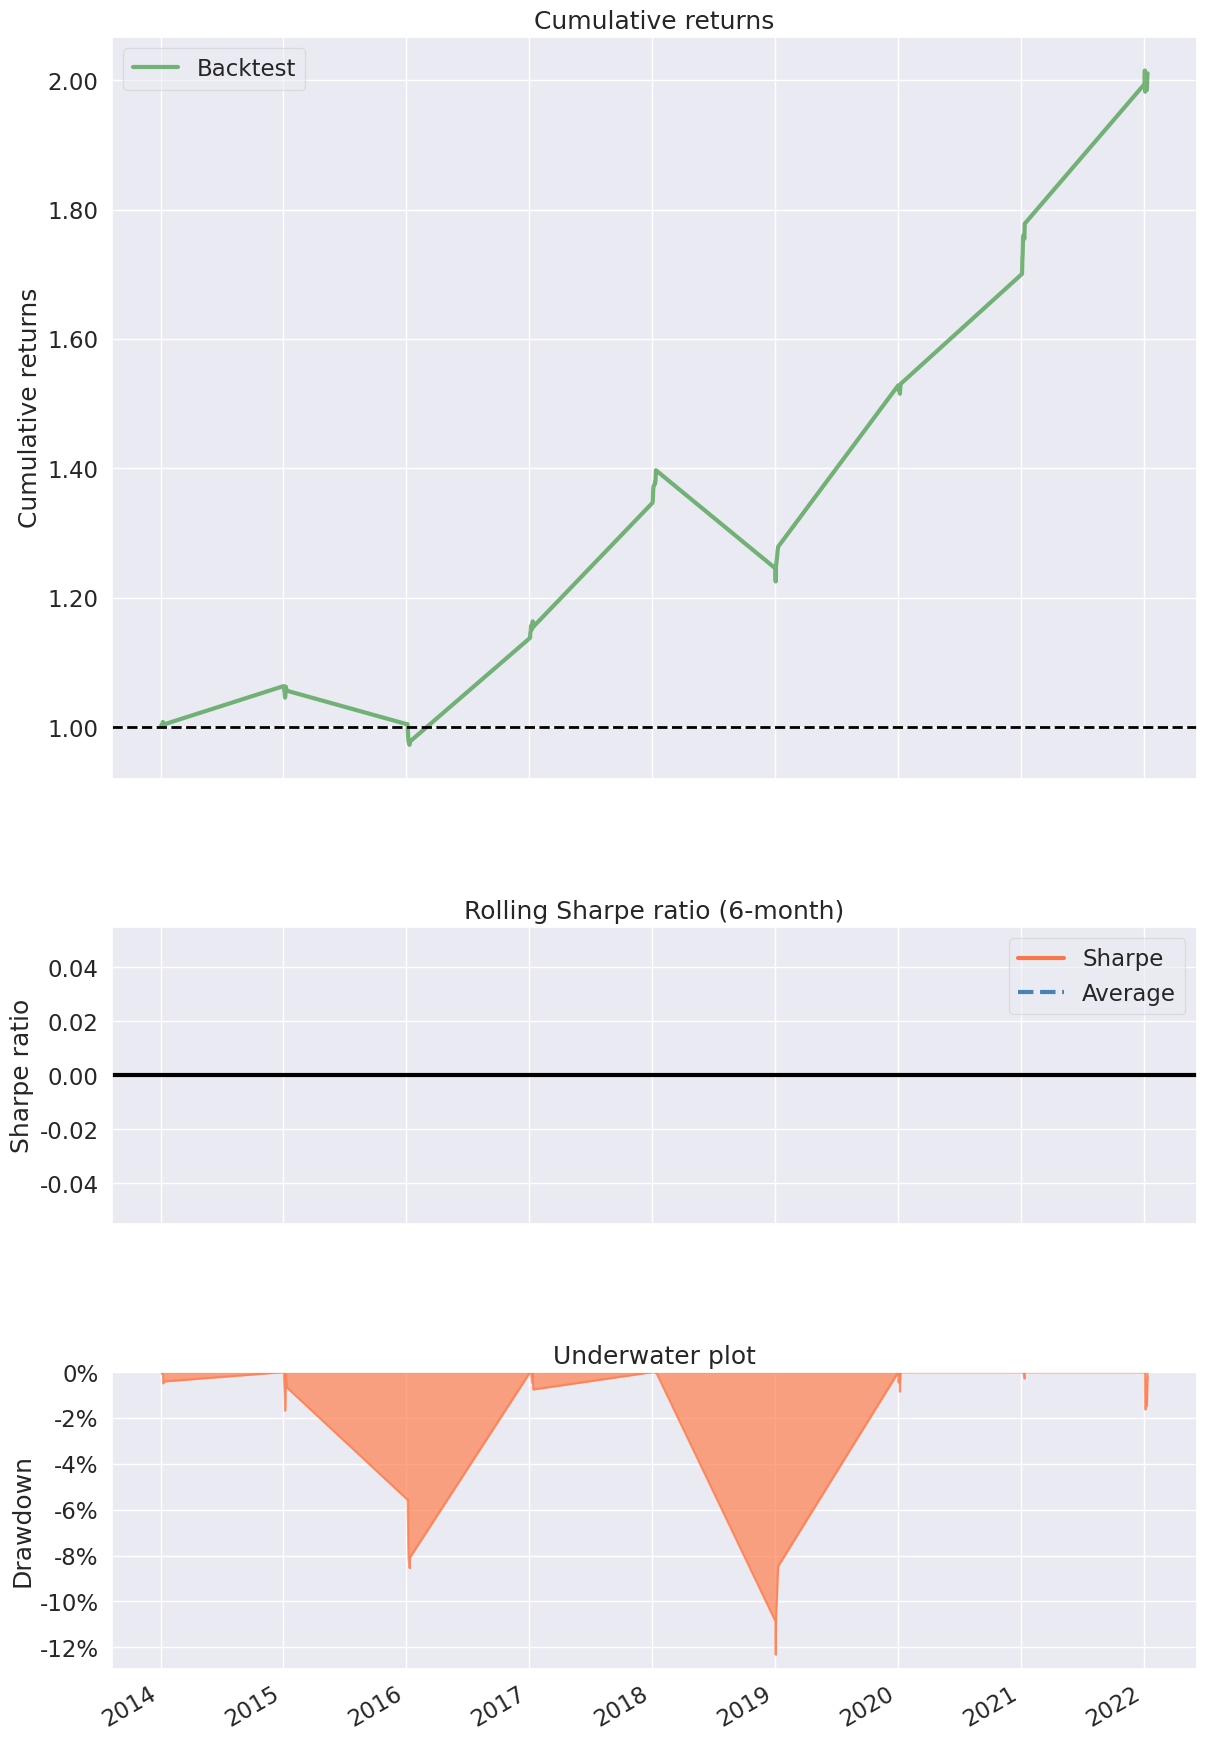

In [ ]:
pf.create_simple_tear_sheet(portfolio_returns_analysis)

Detalle de resultados:

*  **Annual return**: Retorno promedio anual
*  **Cumulative return**: Retorno punta a punta
*  **Annual volatility**: Anualizamos la volatilidad.
*  **Ratio sharpe**: Eficiencia riesgo retorno. Cuánto se espera que gane, por encima del libre riesgo. “Exceso de retorno” por encima de la libre de riesgo.
*  **Calmar ratio**: Es una medida de cómo el rendimiento obtenido por la cartera se compara con el riesgo asumido, representado por el máximo Drawdown.
* **Stability**: Tendencia lineal
* **Max drawdown**: caída máxima que tuviste. Se mide en términos porcentuales.
* **Omega ratio**: Eficiencia riesgo - retorno. Omega define el riesgo, en base a un target objetivo. Por encima del target / por debajo del target. Cuanto más grande el ratio (mejor), estás por arriba de tu target de retornos.
* **Sortino ratio**: Eficiencia riesgo - retorno. Exceso de retorno / Desvío estándar hacia abajo. Si se encuentra por encima no lo consideres.
* **Skew**: Simetría, el signo indica izquierda o derecha.
* **Kurtosis**: Es una medida estadística que describe la forma de la distribución de los datos alrededor de su media. Indica cuán "picuda" o achatada es la distribución en comparación con la distribución normal estándar.
* **Tail Ratio**: Si da 1, indica que los retornos muy buenos son igual a los más malos. Si da bajo, es malo. Las pérdidas extremas son más fuertes que las ganancias extremas. Cuanto representan.
* **VAR, Daily value risk**: En condiciones normales (lo que más frecuente pasa).



#Separacion de muestra: IN-Sample & OUT-Sample

Observaciones de la muestra de train: 68
Observaciones de la muestra de test: 0


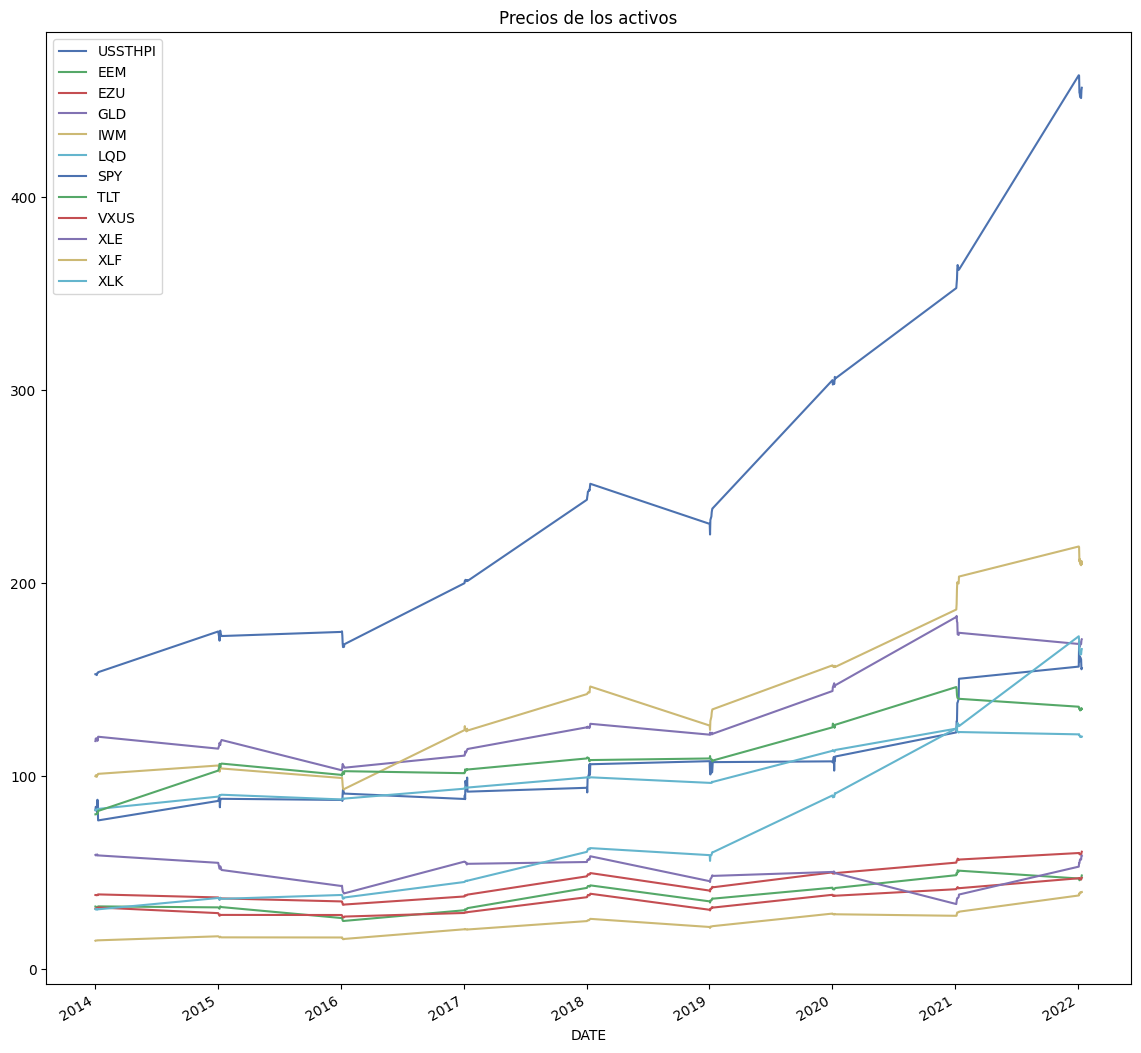

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 14)


#data = data.set_index('Date')

data.plot(title='Precios de los activos')
# returns = data.to_returns()
# returns.plot(title = 'Retornos')

#Separo la muestra de 514 filas en in-sample (primeras 200 observaciones) y out-of-sample (resto de observaciones)
#Buscamos evitar overfitting
data_past = data.iloc[:501,:]
returns_past = data_past.to_returns()
past_length = data_past.shape[0]
data_fwd = data.iloc[501:,:] #desde 501, sino desde 500 comparte una observación con train set (2021-12-31)
returns_fwd = data_fwd.to_returns()
fwd_length = data_fwd.shape[0]
print(f'Observaciones de la muestra de train: {past_length}')
print(f'Observaciones de la muestra de test: {fwd_length}')


#Matriz de Covarianzas

Analizaremos la **matriz de covarianzas** para medir cómo se mueven conjuntamente los rendimientos de nuestros activos financieros seleccionados. Permitiendonos entender, un mayor o menor riesgo sitémico:

*   Si los elementos de la matriz de covarianzas **son altos y positivos** entre dos activos, significa que tienden a moverse juntos, lo que indica un mayor riesgo.
*   Por el contrario, si las covarianzas **son negativas o cercanas a cero**, indica que los activos pueden proporcionar diversificación, ya que sus movimientos tienden a compensarse mutuamente.

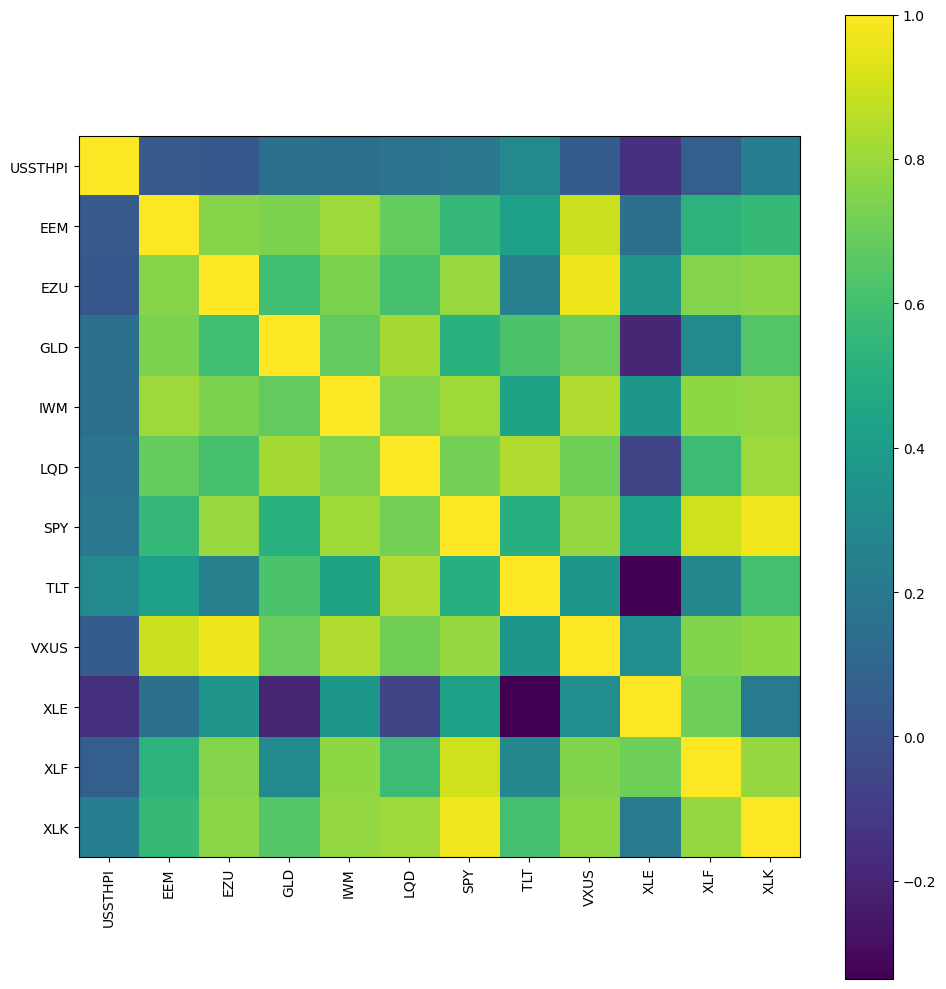

In [ ]:
# Matriz de covarianzas: usamos el cálculo de la matriz de covarianza exponencial del paquete pyportfolioopt para darle más peso a las observaciones recientes, suavizar los valores extremos y reducir la sensibilidad a la variabilidad en los datos históricos
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
exp_cov = risk_models.exp_cov(data_past)
cov_matrix_past = risk_models.exp_cov(data_past)
plotting.plot_covariance(exp_cov, plot_correlation=True)
plt.show()

#plotear solo adj close

#Construcción de portfolios

In [ ]:
# Inicializamos un list of dicts para ir almacenando los portfolios que construiremos:

list_of_portfolios = []

a) **Modern Portfolio Theory (Markowitz)**: Esta estrategia de inversion, enfatiza la importancia de diversificar una cartera invirtiendo en una variedad de activos que no estén perfectamente correlacionados entre sí. Dicho esto, podemos encontrar una combinación óptima de activos que proporciona el máximo rendimiento esperado para cualquier nivel de riesgo dado, o el mínimo riesgo para cualquier nivel de rendimiento esperado. Esta combinación de activos se representa gráficamente como la "frontera eficiente".

In [ ]:

def calculate_portfolio_return(weights, returns):
    portfolio_return = np.dot(returns.mean(), weights)
    return portfolio_return

def calculate_portfolio_volatility(weights, cov_matrix):
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_volatility

def markowitz_optimizer(returns):
    num_assets = len(returns.columns)
    initial_weights = np.ones(num_assets) / num_assets

    # Restricciones para los pesos (entre 0 y 1)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Rango de pesos (entre 0 y 1)
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Función de minimización (volatilidad negativa para maximizar el rendimiento)
    objective_function = lambda weights: -calculate_portfolio_return(weights, returns)

    # Optimización
    result = minimize(objective_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

# Ejemplo de uso
returns = data.pct_change().dropna()
markowitz_weights = markowitz_optimizer(returns)
# Crear un DataFrame con los nombres de los ETFs y sus pesos
etf_names = data.columns
weights_df = pd.DataFrame({'ETF': etf_names, 'Peso': markowitz_weights})

print("Pesos del Portafolio según Modern Portfolio Theory:")
print(weights_df)



Pesos del Portafolio según Modern Portfolio Theory:
        ETF          Peso
0   USSTHPI  1.902932e-17
1       EEM  1.880766e-16
2       EZU  0.000000e+00
3       GLD  8.250937e-17
4       IWM  1.581836e-16
5       LQD  8.561571e-18
6       SPY  7.632783e-16
7       TLT  6.947495e-18
8      VXUS  1.190565e-16
9       XLE  2.473885e-17
10      XLF  0.000000e+00
11      XLK  1.000000e+00


b) **Black and Litterman Model**: es una metodología que permite a los inversores combinar sus opiniones subjetivas con las expectativas objetivas del mercado para formar una cartera óptima que refleje tanto la información disponible como las creencias individuales de los inversores.

Los inversores pueden tener opiniones subjetivas sobre los rendimientos futuros de los activos que difieren de los rendimientos implícitos en los precios de mercado. Estas opiniones pueden basarse en análisis fundamental, investigación económica u otros factores.

Esto proporciona una estructura sistemática para la toma de decisiones de inversión que puede mejorar la gestión de carteras y la asignación de activos.

In [ ]:

def calculate_optimal_weights(expected_returns, cov_matrix):
    # Función de optimización para encontrar los pesos del portafolio
    objective_function = lambda weights: -np.dot(weights, expected_returns)

    # Restricciones para los pesos (entre 0 y 1)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Rango de pesos (entre 0 y 1)
    bounds = tuple((0, 1) for _ in range(len(expected_returns)))

    # Optimización
    result = minimize(objective_function, np.ones(len(expected_returns)) / len(expected_returns), method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

def black_litterman(adj_close, tau, P, Q, asset_names):
    # Calcular los rendimientos esperados del mercado y la matriz de covarianza
    expected_market_returns = adj_close.pct_change().mean()
    cov_matrix = adj_close.pct_change().cov()

    # Calcular el exceso de rendimiento esperado ajustado (pi)
    pi = tau * np.dot(cov_matrix, expected_market_returns)

    # Calcular el nuevo rendimiento esperado ajustado (E[r])
    expected_returns_bl = expected_market_returns + np.dot(np.dot(np.linalg.inv(np.dot(np.dot(np.transpose(P), np.linalg.inv(tau * cov_matrix)), P) + np.linalg.inv(cov_matrix)), pi), (Q - np.dot(P, expected_market_returns)))

    # Calcular la nueva matriz de covarianza ajustada
    cov_matrix_bl = np.linalg.inv(np.linalg.inv(tau * cov_matrix) + np.dot(np.dot(np.transpose(P), np.linalg.inv(np.dot(np.dot(np.transpose(P), np.linalg.inv(tau * cov_matrix)), P) + np.linalg.inv(cov_matrix))), P))

    # Calcular los pesos del portafolio utilizando el nuevo rendimiento esperado y la nueva matriz de covarianza
    bl_weights = calculate_optimal_weights(expected_returns_bl, cov_matrix_bl)

    # Crear un diccionario que asocie los nombres de los activos con sus pesos
    portfolio_dict = {asset_names[i]: bl_weights[i] for i in range(len(asset_names))}

    return portfolio_dict

# Ejemplo de uso
adj_close = df
asset_names = adj_close.columns
tau = 0.025
P = np.eye(len(adj_close.columns))
Q = np.zeros(len(adj_close.columns))

bl_weights = black_litterman(adj_close, tau, P, Q, asset_names)
print("Pesos del Portafolio según Black-Litterman Model:")
for asset, weight in bl_weights.items():
    print(f"{asset}: {weight}")




Pesos del Portafolio según Black-Litterman Model:
USSTHPI: 0.0
EEM: 1.410156771694893e-16
EZU: 1.3743475650585094e-18
GLD: 9.41756872463789e-17
IWM: 4.208669088009098e-17
LQD: 2.7023089140129242e-17
SPY: 5.516420653606247e-16
TLT: 5.061233364718475e-17
VXUS: 6.473454523595921e-17
XLE: 2.2059078853215843e-17
XLF: 9.622213598027618e-17
XLK: 0.999999999999999


Nota: Da igual el % del portfolio con Markowitz y con Black-Litterman. En general, la idea del modelo Black-Litterman es incorporar información adicional al proceso de asignación de activos. Si los resultados son muy similares a la MPT, podría sugerir que la información adicional proporcionada al modelo Black-Litterman no está teniendo un impacto sustancial en la construcción del portafolio.


c) **Hierarchical Risk Parity:** es un enfoque de optimización de carteras que se basa en la estructura jerárquica de las relaciones de covarianza entre activos financieros. Busca mejorar la diversificación y el control del riesgo.

Al asignar pesos de manera óptima a los clústeres y activos dentro de cada clúster, HRP busca construir carteras que sean más resistentes a la volatilidad y que proporcionen un rendimiento más estable a lo largo del tiempo.

Pesos del Portafolio HRP:
OrderedDict([('USSTHPI', 0.16084), ('EEM', 0.02414), ('EZU', 0.03538), ('GLD', 0.17851), ('IWM', 0.05506), ('LQD', 0.21829), ('SPY', 0.02812), ('TLT', 0.08933), ('VXUS', 0.11474), ('XLE', 0.0445), ('XLF', 0.03981), ('XLK', 0.01126)])
Expected annual return: 219.6%
Annual volatility: 52.1%
Sharpe Ratio: 4.18


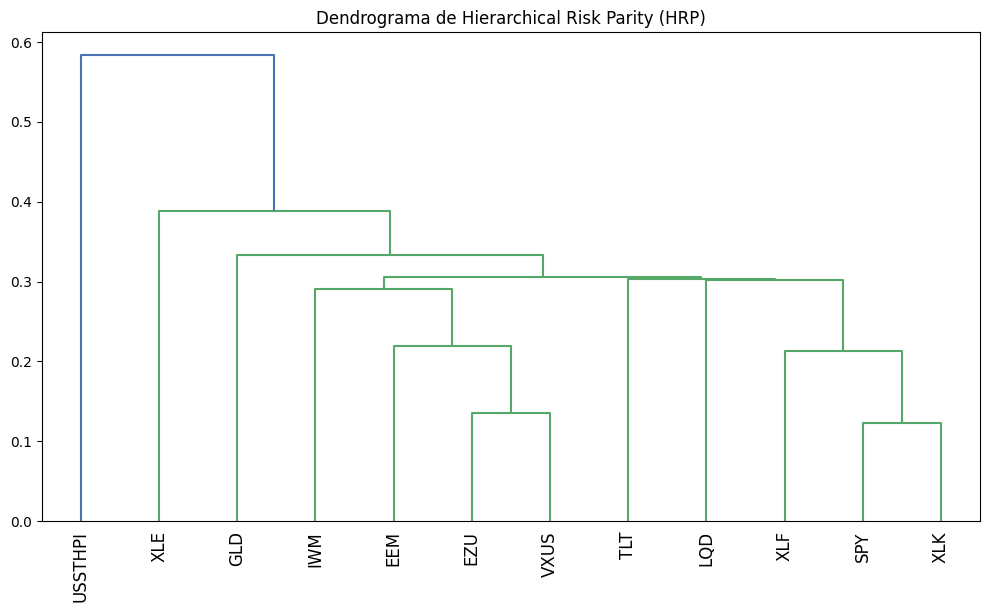

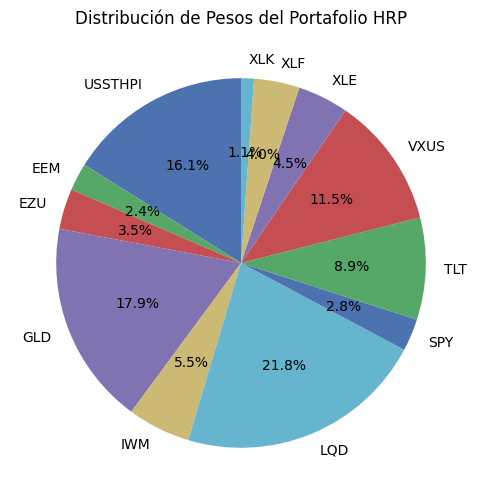

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 7)
# Se optimiza el portafolio y se imprimen los resultados
hrp = HRPOpt(returns_past)
hrp.optimize()
hrp_weights = hrp.clean_weights()
print("Pesos del Portafolio HRP:")
print(hrp_weights)

# Mostrar el rendimiento del portafolio
hrp.portfolio_performance(verbose=True);

#Agrego los weights de HRP al diccionario de portfolios
list_of_portfolios = {'HRP': dict(hrp_weights)}

# Plotear el dendrograma
plt.figure(figsize=(10, 6))
plotting.plot_dendrogram(hrp)
plt.title('Dendrograma de Hierarchical Risk Parity (HRP)')
plt.show()

# Plotear el gráfico de torta para los pesos
plt.figure(figsize=(6, 6))
pd.Series(hrp_weights).plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Pesos del Portafolio HRP')
plt.show()




e) **Simple Return-Agnostic Strategies** (Equally Weighted y Minimum Variance): Son enfoques de construcción de carteras que se centran únicamente en la estructura de riesgo de los activos subyacentes, sin considerar las expectativas de retorno específicas de cada activo.

Estas estrategias son adecuadas cuando los inversores desean minimizar el riesgo y la volatilidad de su cartera sin realizar pronósticos de rendimiento.

Podemos encontrar dos estrategias:

1.   **Equally Weighted (Ponderación Igual)**: En esta estrategia, todos los activos en la cartera se ponderan de manera igual, es decir, cada activo contribuye con la misma cantidad al valor total de la cartera. La principal ventaja de esta estrategia es su simplicidad y su fácil implementación.
Sin embargo, puede llevar a una menor eficiencia en términos de riesgo ajustado al rendimiento en comparación con otras estrategias más sofisticadas que tienen en cuenta la estructura de riesgo.
2.   **Minimum Variance (Varianza Mínima):** En esta estrategia, se busca construir una cartera que minimice la varianza total del portafolio, es decir, se busca una combinación de activos que tenga la menor volatilidad posible. Esta estrategia es adecuada para inversores que desean minimizar el riesgo de su cartera y están dispuestos a sacrificar rendimientos potenciales en busca de una mayor estabilidad y previsibilidad en el rendimiento.



In [ ]:

# e.1) Equally Weighted
equally_weighted_weights = np.ones(len(data.columns)) / len(data.columns)
equally_weighted_portfolio = {asset: weight for asset, weight in zip(data.columns, equally_weighted_weights)}
print("Pesos del Portafolio según Estrategia Equally Weighted:")
print(equally_weighted_portfolio)

# e.2) Minimum Variance
cov_matrix = returns.cov()
inv_cov_matrix = np.linalg.inv(cov_matrix)
min_variance_weights = inv_cov_matrix.sum(axis=1) / np.sum(inv_cov_matrix.sum(axis=1))
min_variance_portfolio = {asset: weight for asset, weight in zip(data.columns, min_variance_weights)}
print("Pesos del Portafolio según Estrategia Minimum Variance:")
print(min_variance_portfolio)



Pesos del Portafolio según Estrategia Equally Weighted:
{'USSTHPI': 0.08333333333333333, 'EEM': 0.08333333333333333, 'EZU': 0.08333333333333333, 'GLD': 0.08333333333333333, 'IWM': 0.08333333333333333, 'LQD': 0.08333333333333333, 'SPY': 0.08333333333333333, 'TLT': 0.08333333333333333, 'VXUS': 0.08333333333333333, 'XLE': 0.08333333333333333, 'XLF': 0.08333333333333333, 'XLK': 0.08333333333333333}
Pesos del Portafolio según Estrategia Minimum Variance:
{'USSTHPI': 0.04083821820565019, 'EEM': 0.04499617648981751, 'EZU': -0.046649278680833364, 'GLD': -0.05850640496671054, 'IWM': -0.10186464620903035, 'LQD': 1.3268332104632086, 'SPY': 2.0783793237656103, 'TLT': -0.5390108828862644, 'VXUS': -0.10685482777509647, 'XLE': -0.10348608702507775, 'XLF': -0.5255633344800656, 'XLK': -1.0091114669012082}


f) **Classic Balanced Portfolio (CBP)**: Es una estrategia de inversión tradicional que busca un equilibrio entre el riesgo y el rendimiento mediante la asignación de activos en diferentes clases de activos, como acciones, bonos y efectivo. Esta estrategia se basa en los principios de diversificación y gestión de riesgos para proporcionar un rendimiento estable y una protección contra la volatilidad del mercado

Generalmente asigna una parte de la cartera a acciones para aprovechar el potencial de crecimiento a largo plazo y otra parte a bonos para proporcionar estabilidad y generación de ingresos.

Se basa en el principio de diversificación, que consiste en distribuir los activos entre diferentes clases de activos y geografías para reducir el riesgo total de la cartera

Es una estrategia diseñada para inversionistas con horizontes de inversión a largo plazo



In [ ]:
# e.3) Classic Balanced Portfolio
equity_weight = 0.6
bond_weight = 0.4
cbp_weights = np.array([equity_weight / len(data.columns)] * (len(data.columns) - 1) + [bond_weight])

# Imprimir los pesos del portafolio junto con los nombres de los activos
print("Pesos del Portafolio según Classic Balanced Portfolio:")
for asset, weight in zip(data.columns, cbp_weights):
    print(f"{asset}: {weight}")


Pesos del Portafolio según Classic Balanced Portfolio:
USSTHPI: 0.049999999999999996
EEM: 0.049999999999999996
EZU: 0.049999999999999996
GLD: 0.049999999999999996
IWM: 0.049999999999999996
LQD: 0.049999999999999996
SPY: 0.049999999999999996
TLT: 0.049999999999999996
VXUS: 0.049999999999999996
XLE: 0.049999999999999996
XLF: 0.049999999999999996
XLK: 0.4


g) **Permanent Portfolio (PEP)**: Es una estrategia de inversión diseñada para proporcionar un equilibrio entre riesgo y rendimiento a largo plazo, independientemente de las condiciones económicas y de mercado. Se basa en la premisa de que los inversores deben protegerse contra cuatro posibles escenarios económicos: **inflación, deflación, crecimiento económico y recesión.**

La estrategia de Permanent Portfolio se compone de cuatro clases de activos principales, cada una diseñada para prosperar en uno de los cuatro escenarios económicos mencionados anteriormente. Estas clases de activos son:

*   **Bonos de Largo Plazo**: Los bonos de largo plazo proporcionan protección contra la deflación y tienden a tener un buen desempeño cuando las tasas de interés disminuyen.
*   **Acciones**: Las acciones proporcionan crecimiento y protección contra la inflación. A pesar de ser más volátiles a corto plazo, históricamente han superado a otras clases de activos en términos de rendimiento a largo plazo.
*   **Oro**: El oro es un refugio seguro tradicional que tiende a tener un buen desempeño durante la inflación y la incertidumbre económica. Actúa como una cobertura contra la devaluación de la moneda y la inflación.
*   **Efectivo**: El efectivo, generalmente en forma de bonos del Tesoro de corto plazo, proporciona liquidez y estabilidad a la cartera. Sirve como protección contra la recesión y permite aprovechar oportunidades de inversión cuando los activos están infravalorados.

La asignación de activos en el Permanent Portfolio suele ser equitativa, es decir, el 25% de la cartera se asigna a cada una de las cuatro clases de activos mencionadas anteriormente. Esta asignación equilibrada ayuda a diversificar el riesgo y proporcionar una protección contra una amplia gama de condiciones económicas.

In [ ]:


# Asignar los porcentajes según la estrategia PEP
pep_weights = {
    'IWM': 0.25,   # 25% en acciones (stocks)
    'SPY': 0.25,   # 25% en acciones (stocks)
    'GLD': 0.25,   # 25% en oro (gold)
    'TLT': 0.25    # 25% en bonos del gobierno a largo plazo (long-term treasury bonds)
}

# Verificar si todos los tickers en pep_weights están en etf_tickers
if set(pep_weights.keys()).issubset(etf_tickers):
    print("Pesos del Portafolio según Permanent Portfolio (PEP):")
    print(pep_weights)
else:
    print("Error: Algunos tickers en pep_weights no están en etf_tickers.")



Pesos del Portafolio según Permanent Portfolio (PEP):
{'IWM': 0.25, 'SPY': 0.25, 'GLD': 0.25, 'TLT': 0.25}


¿Siempre es necesario el detoning de la matriz (estimada) de varianzas y covarianzas para cada una de las estrategias de construcción de portafolio propuestas?

No siempre, ya que dependera de la **calidad de los datos, volatilidad del mercado y la frecuencia de reequilibrio del activo.**

Cuando es necesario:

*   Si existen valores atípicos o extremos que no son representativos de las condiciones normales del mercado
*  En períodos de alta volatilidad o inestabilidad del mercado

El detoning puede ser necesario para reducir su impacto en los resultados de la estrategia y a mitigar el riesgo de sobreestimación del riesgo.

Sin embargo, cuando la cartera se rebalancea con frecuencia, el detoning puede no ser necesario o puede ser menos crítico.

Una de las principales desventajas corresponde a la pérdida de información, distorciona las relaciones de riesgo y rendimiento entre los activos y sobrestimar la estabilidad de la cartera.

# Montecarlo

1. Realicemos un ejercicio de Montecarlo donde generamos 100 retornos mensuales para cada activo, recuerde que los retornos tienen correlación entre sí. En base a esos retornos generados simule la performance de cada estrategia in sample y out of sample.

Fuente: https://github.com/PacktPublishing/Python-for-Finance-Cookbook/blob/master/Chapter%2006/chapter_6.ipynb


In [ ]:
# set random seed for reproducibility
np.random.seed(42)
#Parámetros usados
RISKY_ASSETS = list(data.columns)
SHARES = [5, 5]

T = 1
N_SIMS = 10 ** 5

In [ ]:
df = data


In [ ]:
df.head()

,USSTHPI,EEM,EZU,GLD,IWM,LQD,SPY,TLT,VXUS,XLE,XLF,XLK
DATE,,,,,,,,,,,,
2014-01-02,82.2,32.273502,31.185854,118.000000,99.790016,82.334030,152.669128,80.040108,38.236805,58.996796,14.562067,30.888838
2014-01-03,83.9,32.217285,31.100878,119.290001,100.297226,82.456367,152.644058,80.040108,38.221954,58.780449,14.662543,30.740454
2014-01-06,84.0,31.912140,31.193579,119.500000,99.483932,82.636292,152.201767,80.376976,38.110508,58.861580,14.675937,30.688089
2014-01-07,80.1,32.048660,31.502581,118.820000,100.314720,82.571518,153.136551,80.580673,38.296265,59.307861,14.682635,30.967386
2014-01-08,87.6,31.944275,31.471689,118.120003,100.445877,82.218903,153.169891,80.361313,38.273975,58.895397,14.729525,30.967386


In [ ]:
#matriz de covarianzas
cov_mat = returns.cov()
cov_mat

,USSTHPI,EEM,EZU,GLD,IWM,LQD,SPY,TLT,VXUS,XLE,XLF,XLK
USSTHPI,0.002018,0.000080,-0.000015,0.000224,0.000283,0.000219,0.000541,0.000616,0.000050,-0.000620,0.000240,0.001026
EEM,0.000080,0.004395,0.002799,0.002173,0.003140,0.001212,0.002493,0.001007,0.002985,0.001545,0.002833,0.003842
EZU,-0.000015,0.002799,0.002999,0.001444,0.002257,0.000864,0.002647,0.000396,0.002628,0.001788,0.002888,0.004060
GLD,0.000224,0.002173,0.001444,0.001966,0.001690,0.000944,0.001446,0.000982,0.001526,-0.000371,0.001033,0.002764
IWM,0.000283,0.003140,0.002257,0.001690,0.003386,0.001164,0.003005,0.000938,0.002411,0.002359,0.003425,0.004520
LQD,0.000219,0.001212,0.000864,0.000944,0.001164,0.000749,0.001309,0.000956,0.000936,0.000014,0.001246,0.002246
SPY,0.000541,0.002493,0.002647,0.001446,0.003005,0.001309,0.004034,0.001380,0.002476,0.002396,0.004223,0.006184
TLT,0.000616,0.001007,0.000396,0.000982,0.000938,0.000956,0.001380,0.001832,0.000622,-0.001100,0.000980,0.002532
VXUS,0.000050,0.002985,0.002628,0.001526,0.002411,0.000936,0.002476,0.000622,0.002483,0.001614,0.002736,0.003802
XLE,-0.000620,0.001545,0.001788,-0.000371,0.002359,0.000014,0.002396,-0.001100,0.001614,0.007888,0.004542,0.001913


In [ ]:
#descomposición de Cholesky
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[ 4.49260744e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.78513647e-03,  6.62700090e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.42810699e-04,  4.22405909e-02,  3.48564725e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.97729132e-03,  3.26552074e-02,  1.89197202e-03,
         2.95259567e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.30166905e-03,  4.72113555e-02,  7.6039103

In [ ]:
def sim_retornos_correlacionados(returns, n_samples = 1, from_date = returns.index.max(), date_freq = 'MS'):


  # Denoising y detoning: Shrinkage de Covariance para obtener la covarianza deseada
  cov_shrinkage = CovarianceShrinkage(returns.cov())
  shrinkage_cov = cov_shrinkage.shrunk_covariance()
  # Calcular la descomposición de Cholesky de la matriz de covarianza
  chol_mat = sqrtm(shrinkage_cov)

  #media y desvio de cada retorno
  means = returns.mean()
  std_devs = returns.std()

  #fechas inventadas, para que sea mas simple agrupar despues
  date_index = pd.date_range(start=pd.Timestamp(from_date), periods=n_samples, freq=date_freq)# MS = months, D = days

  # dataframe vacio
  simulated_returns = pd.DataFrame()

  # Para cada retorno de un activo (columna) creamos una distribución normal con
  # media igual a su media muestral y desvio igual a su desvio muestral
  for column in returns.columns:

    # generamos retornos aleatorios
    simulated_values = np.random.normal(loc=means[column], scale=std_devs[column], size=n_samples)

    # agregamos los datos al dataframe
    simulated_returns[column] = simulated_values

  # fechas inventadas como indice
  simulated_returns.index = date_index

  return simulated_returns

montecarlo_results = sim_retornos_correlacionados(returns, n_samples = 100)
print(montecarlo_results)

             USSTHPI       EEM       EZU       GLD       IWM       LQD  \
2022-02-01  0.016180 -0.036210 -0.049724  0.040943  0.002000  0.015626   
2022-03-01 -0.008737  0.073847  0.037002 -0.018016  0.092642  0.019419   
2022-04-01  0.016048 -0.003518  0.072548 -0.029856 -0.024944  0.023404   
2022-05-01  0.034962 -0.042021  0.046986  0.006277 -0.033860  0.036407   
2022-06-01  0.012749  0.043648  0.062161 -0.001120 -0.015447  0.017247   
...              ...       ...       ...       ...       ...       ...   
2030-01-01  0.006111  0.020324  0.117478 -0.038350  0.125463 -0.014559   
2030-02-01  0.051845 -0.081226  0.120512  0.033883 -0.045564 -0.002707   
2030-03-01 -0.002487 -0.056332  0.073789  0.097667 -0.026794 -0.015765   
2030-04-01  0.022567  0.087661  0.063695  0.007349  0.042545  0.035484   
2030-05-01  0.025007 -0.035468  0.040062 -0.025857  0.023092  0.006611   

                 SPY       TLT      VXUS       XLE       XLF       XLK  
2022-02-01  0.138987  0.038419 -0.0255

In [ ]:
# Performance de cada portafolio en la simulación de montecarlo

# a) Modern Portfolio Theory (Markovitz)
portfolio_markowitz_montecarlo = np.dot(montecarlo_results,markowitz_weights)
print(f'Retorno del portafolio por Markowitz: {np.prod(portfolio_markowitz_montecarlo + 1) - 1}')

# b) Black and Litterman model
bl_weights_values = []
for x in bl_weights.values():
  bl_weights_values.append(x)
portfolio_bl_montecarlo = np.dot(montecarlo_results,bl_weights_values)
print(f'Retorno del portafolio por Black and Litterman model: {np.prod(portfolio_bl_montecarlo + 1) - 1}')

# c) Hierarchical Risk Parity
hrp_weights_values = []
for x in hrp_weights.values():
  hrp_weights_values.append(x)
portfolio_hrp_montecarlo = np.dot(montecarlo_results,hrp_weights_values)
print(f'Retorno del portafolio por Hierarchical Risk Parity: {np.prod(portfolio_hrp_montecarlo + 1) - 1}')

# d) Growth Optimal Portfolio Theory

# e) simple return-agnostic strategies.
portfolio_min_variance_montecarlo = np.dot(montecarlo_results,min_variance_weights)
print(f'Retorno del portafolio por simple return-agnostic strategies.: {np.prod(portfolio_min_variance_montecarlo + 1) - 1}')

# f) Classic Balanced Portfolio (CBP)
# Normalizar los pesos para asegurar que sumen 1
cbp_weights_sum = sum(cbp_weights)
cbp_weights_normalized = [w / cbp_weights_sum for w in cbp_weights]

portfolio_cbp_montecarlo_normal = np.dot(montecarlo_results,cbp_weights_normalized)
print(f'Retorno del portafolio por Classic Balanced Portfolio (CBP) normalizado: {np.prod(portfolio_cbp_montecarlo_normal + 1) - 1}')


Retorno del portafolio por Markowitz: 9.472623270618078
Retorno del portafolio por Black and Litterman model: 9.472623270618085
Retorno del portafolio por Hierarchical Risk Parity: 1.4557768740854935
Retorno del portafolio por simple return-agnostic strategies.: -0.9100608152047156
Retorno del portafolio por Classic Balanced Portfolio (CBP) normalizado: 4.66150435788799


# Forecasting Portfolio VaR - Modelo GARCH

**Forecasting Portfolio VaR con modelos GARCH**:

Los modelos GARCH (Heterocedasticidad Condicional Autorregresiva Generalizada)  buscan estimar la volatilidad (desvio estandard de un retorno).

Dados los retornos observados de ciertos activos, se arma un modelo simple para los retornos y despues trabaja con los residuos de dicho modelo (intenta modelarlos).






In [ ]:
# 2. ---------------------------------------------------------------------------
# primero calculamos los retornos trimestrales

selected_portfolio = pd.DataFrame({'date':montecarlo_results.index,
              'portfolio_markowitz_returns':portfolio_markowitz_montecarlo})

# calculamos los trimestres
selected_portfolio['trimestre'] = selected_portfolio['date'].dt.to_period('Q')

# agrupamos por trimestre y calculamos el retorno acumulado cada 3 meses
quarterly_returns = selected_portfolio.groupby('trimestre')['portfolio_markowitz_returns'].apply(lambda x: (1 + x).prod() - 1)


print(quarterly_returns.head())


# a. ¿Qué es lo peor que podría pasar en un trimestre normal?
print(f'Lo peor que puede pasar en un trimestre (1% de probabilidad) es: {np.percentile(quarterly_returns, 0.01)}')

# Reescalamos los datos para evitar error en forecasting:

#DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
#estimating the model parameters. The scale of y is 0.001467. Parameter
#estimation work better when this value is between 1 and 1000. The recommended
#rescaling is 10 * y.
scaled_returns = 10 * quarterly_returns


# b. modelo GARCH (1,1) para las serie de retornos del portafolio.
model = arch_model(scaled_returns, mean='Zero', vol='GARCH', p=1, o=0,q=1)
model_fitted = model.fit(disp='off')
print(model_fitted.summary())


# c.
# volatilidad condicional pronosticada a 1 trimestre en base al GARCH(1,1).
forecast = model_fitted.forecast(horizon = 1)
cond_vol = np.sqrt(forecast.variance['h.1'])/10# divido por 10 para reescalar (deshacer el escalado anterior)
print(cond_vol)

# U_p es la media del portfolio
u_p = selected_portfolio.portfolio_markowitz_returns.mean()
print(u_p)

# y q_0.01^z es valor crítico z para un nivel de confianza del 1%
q_01 = norm.ppf(0.01)
print(q_01)

# entonces la función del Value at Risk (VaR) al 99% de confianza se define como
VaR_99 = float(u_p + cond_vol * q_01)
print(f'Value at Risk (VaR) trimestral al 99% de confianza: {VaR_99}')


# d.  VaR diario y mensual al mismo nivel de confianza
# (asumiendo retornos independientes entre si)
VaR_99_mensual = VaR_99/np.sqrt(3)
VaR_99_diario = VaR_99_mensual/np.sqrt(30)

print(f'Value at Risk (VaR) mensual al 99% de confianza {VaR_99_mensual}')
print(f'Value at Risk (VaR) diario al 99% de confianza {VaR_99_diario}')

#TODO:
# el VaR parece que lo pide como "retorno VaR" que es el que usé,
# si fuera VaR a secas seria el precio del portafolio, por ejemplo U$D 15.000
# en un mal evento del 1% de probabilidad

trimestre
2022Q1    0.054697
2022Q2    0.284998
2022Q3    0.478940
2022Q4    0.208103
2023Q1    0.374240
Freq: Q-DEC, Name: portfolio_markowitz_returns, dtype: float64
Lo peor que puede pasar en un trimestre (1% de probabilidad) es: -0.23067350125152436
                            Zero Mean - GARCH Model Results                            
Dep. Variable:     portfolio_markowitz_returns   R-squared:                       0.000
Mean Model:                          Zero Mean   Adj. R-squared:                  0.029
Vol Model:                               GARCH   Log-Likelihood:               -68.7592
Distribution:                           Normal   AIC:                           143.518
Method:                     Maximum Likelihood   BIC:                           148.098
                                                 No. Observations:                   34
Date:                         Thu, Feb 29 2024   Df Residuals:                       34
Time:                                 00:2

In [ ]:
model = arch_model(data.EEM, mean='Zero', vol='GARCH', p=1, o=0,q=1)

**OJO: Esta realizado solo con un ETF (data.EEM).. pero despues deberiamos usar el portafolio seleccionado**

Tenemos 2 hiperparámetros:

*   p: The number of lag variances
*   q: The number of lag residual errors from a mean process

In [ ]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    EEM   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.015
Vol Model:                      GARCH   Log-Likelihood:               -341.916
Distribution:                  Normal   AIC:                           689.833
Method:            Maximum Likelihood   BIC:                           696.491
                                        No. Observations:                   68
Date:                Thu, Feb 29 2024   Df Residuals:                       68
Time:                        00:21:36   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         29.4150     55.634      0.529      0.597 

Salida - Estimaciones para los parametros del modelo para volatilidad:

*   Omega: Intecepto constante en el tiempo
*   Alpha: Coeficiente estimado (acompaña primer rezago)

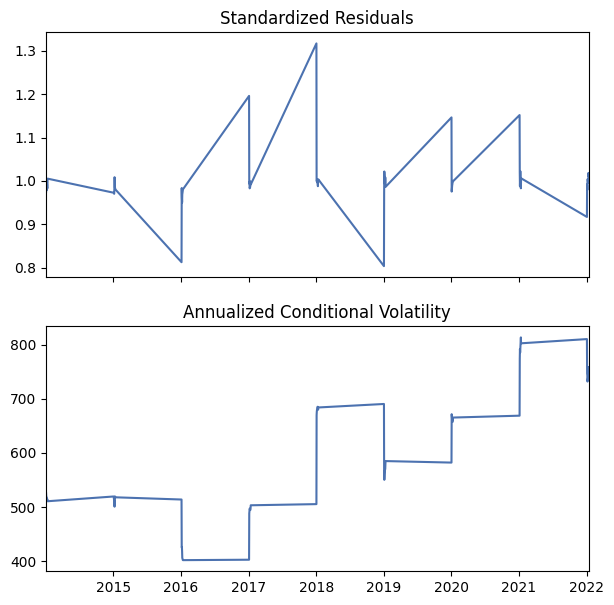

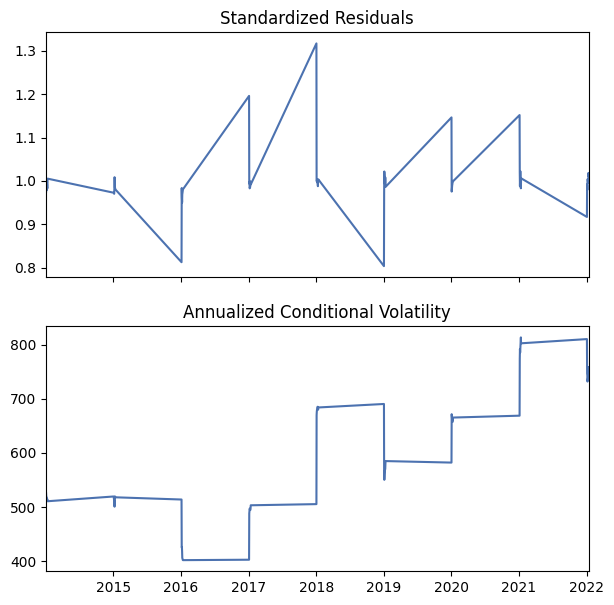

In [ ]:
model_fitted.plot(annualize='D')

El siguiente código descarga datos históricos de precios de activos financieros, implementa tres estrategias de rebalanceo de cartera: Buy-and-Hold, Constant-Mix y Constant Proportion Portfolio Insurance (CPPI).Finalmente, visualiza el rendimiento de estas estrategias a lo largo del tiempo.

[*********************100%%**********************]  11 of 11 completed


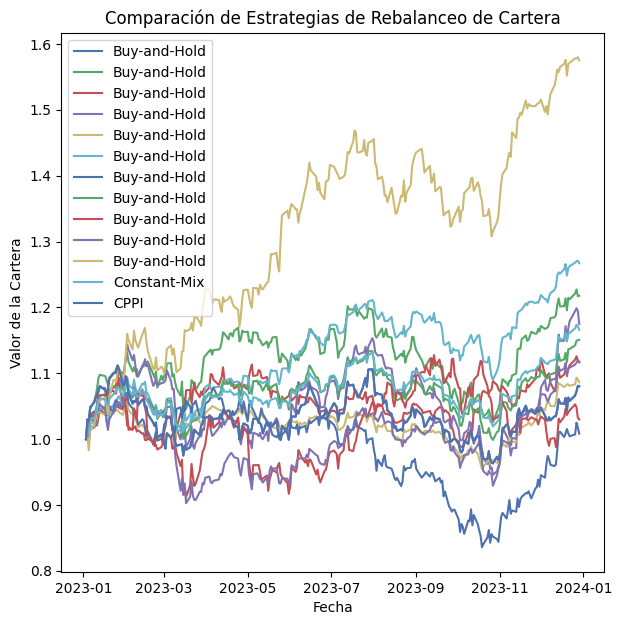

In [ ]:
# Descargar datos históricos de precios de los activos
etf_tickers = ['IWM', 'SPY', 'VXUS', 'LQD', 'TLT', 'GLD', 'XLE', 'XLK', 'XLF', 'EZU', 'EEM']
df = yf.download(etf_tickers, start='2023-01-01', end='2023-12-31')['Adj Close']

# Reemplazar infinitos y NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Definir estrategias de rebalanceo

def buy_and_hold(data):
    return data / data.iloc[0]

def constant_mix(data, weights):
    target_weights = weights / np.sum(weights)
    returns = data.pct_change().fillna(0)
    cumulative_returns = (returns * target_weights).sum(axis=1) + 1
    return cumulative_returns.cumprod()

def constant_proportion_portfolio_insurance(data, floor, multiplier):
    returns = data.pct_change().fillna(0)

    value = 1
    portfolio_value = [value]
    for i in range(1, len(data)):
        cushion = (value - (floor * value)) / value
        weight_equity = min(max(1, cushion * multiplier), 1)
        weight_bonds = 1 - weight_equity
        value *= (1 + returns.iloc[i, 0] * weight_equity + returns.iloc[i, 1] * weight_bonds)
        portfolio_value.append(value)

    portfolio = pd.DataFrame({'CPPI': pd.Series(portfolio_value,
                                    index = returns.index)})
    return portfolio


# Simular rebalanceo y calcular métricas de desempeño

buy_and_hold_returns = buy_and_hold(df)
constant_mix_returns = constant_mix(df, np.ones(len(etf_tickers)))
constant_proportion_portfolio_insurance_returns = constant_proportion_portfolio_insurance(df, 0.8, 3)

# Visualización de resultados

import matplotlib.pyplot as plt

plt.plot(buy_and_hold_returns, label='Buy-and-Hold')
plt.plot(constant_mix_returns, label='Constant-Mix')
plt.plot(constant_proportion_portfolio_insurance_returns, label='CPPI') #Esta línea plotea los resultados en 1970 cuando no hay data en esa fecha
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Valor de la Cartera')
plt.title('Comparación de Estrategias de Rebalanceo de Cartera')
plt.show()



Optativo. Constant Proportion Portfolio Insurance (CPPI). Usted sabe que
necesita contar con 500 mil usd dentro de un año, la tasa libre de riesgo es 4% anual. Calcule el floor, cushion y los shares de equities y bonos (para un portafolio simplificado con 2 activos: 1 fondo o etfs de equities y otro de bonos)

In [ ]:
# Definir los parámetros
valor_total_portafolio = 500000  # Valor total del portafolio
r = 0.04     # Tasa libre de riesgo anual (4%)
t = 1        # Tiempo en años
proporcion_equities = 0.7  # Porcentaje de equities (por ejemplo, 70%)
proporcion_bonos = 0.3  # Porcentaje de bonos (por ejemplo, 30%)

# Calcular el valor presente (PV) utilizando la fórmula del valor futuro
PV_actual = valor_total_portafolio / ((1 + r) ** t)

# Calcular el floor (piso) como el 80% del valor presente
floor = 0.80 * PV_actual

# Calcular el cushion (amortiguador)
cushion = PV_actual - floor

# Calcular las participaciones en equities y bonos en función de las proporciones dadas
shares_equities = proporcion_equities * valor_total_portafolio
shares_bonos = proporcion_bonos * valor_total_portafolio

# Imprimir los resultados
print("Valor presente necesario hoy: {:.2f}".format(PV_actual))
print("Floor (piso): {:.2f}".format(floor))
print("Cushion (amortiguador): {:.2f}".format(cushion))
print("Participaciones en Equities: {:.2f}".format(shares_equities), " || 70% del portfolio")
print("Participaciones en Bonos: {:.2f}".format(shares_bonos)," || 30% del portfolio")


Valor presente necesario hoy: 480769.23
Floor (piso): 384615.38
Cushion (amortiguador): 96153.85
Participaciones en Equities: 350000.00  || 70% del portfolio
Participaciones en Bonos: 150000.00  || 30% del portfolio
